In [37]:
import sys 
import os
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import astropy.constants as c
import astropy.units as u
from astropy.io import fits
from IPython.display import display
import logging
from pathlib import Path
from datetime import datetime
# import pyregion
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.coordinates import SkyCoord
import importlib
import pickle
import pandas as pd
try:
    logging.getLogger('matplotlib').disabled = True
except:
    pass
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)
import shutil
from astropy.table import QTable, Table
from astropy.modeling.models import Gaussian2D
from matplotlib.patches import (Ellipse, Rectangle)
import matplotlib.patches as mpatches
import itertools
import shapely
import shapely.plotting
from shapely.geometry.point import Point
from shapely import affinity
from scipy.integrate import dblquad
from uncertainties import ufloat
from scipy.optimize import curve_fit
from astropy.visualization import (
    MinMaxInterval, 
    SqrtStretch,
    ImageNormalize,
    simple_norm
)
from astropy import visualization
from astropy.modeling.models import Gaussian1D
import matplotlib.cm as cm
from pprint import pprint
import pylustrator
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models
from astropy.convolution.kernels import CustomKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.utils._parameters import as_pair
from astropy.convolution import discretize_model
from photutils.aperture import CircularAperture, EllipticalAperture
from IPython.display import display
import ipywidgets as widgets
from matplotlib import rc

In [2]:
ROOT_DIR = os.path.dirname(os.path.realpath('__file__'))
PROG_DIR = os.path.abspath('./mirar')
os.chdir(PROG_DIR)

In [14]:
def test_path(name):
    if isinstance(name,tuple):
        return Path(os.path.abspath(os.path.join(TEST_DIR,*name)))
    else:
        return Path(os.path.abspath(os.path.join(TEST_DIR,name)))
    
def make_test_dirs():
    for dir in OUTPUT_DIRS.values():
        os.makedirs(dir, exist_ok=True)
        
def move_to_raw(path):
    path = Path(path)
    dst = os.path.join(RAW_DIR,path.name)
    shutil.copyfile(path,dst)
    
def prepare(src_dir,src_basenames):
    for file in os.listdir(src_dir):
        for basename in src_basenames:
            if basename in file:
                move_to_raw(os.path.join(src_dir,file)) 
                
def save_params(path):
    with open(path,'w') as file:
        file.write(_ih[-1])
        
DATA_DIR = os.path.join(ROOT_DIR,'SampleData')

TEST_ID = '2'
TEST_DIR = os.path.abspath(os.path.join(ROOT_DIR,'test_'+TEST_ID))
OUTPUT_DIRS = {
    'BKG': test_path('background'),
    'DET': test_path('detection'),
    'PSF_MODEL': test_path('psf_model'),
    'PHOTCAL': test_path('photcal'),
    'PSF_PHOT': test_path('psf_phot'),
    'APER_PHOT': test_path('aper_phot'),
    'LOG': test_path('log'),
    'CONF': test_path('config'),
    'RES': test_path('results'),
    'CAT': test_path('catalogs'),
    'XMAT': test_path('xmatch'),
    'SEE': test_path('seeing'),
    'MASK': test_path('mask'),
    'FLAT': test_path('flat'),
}
make_test_dirs()

RAW_DIR = os.path.join(TEST_DIR,'raw')
os.makedirs(RAW_DIR, exist_ok=True)

LOGGING = True
LOG_FILE = os.path.abspath(os.path.join(OUTPUT_DIRS['LOG'],f"test{TEST_ID}_{datetime.now()}"))
if LOGGING:
    logger = logging.getLogger(__name__)
    logging.basicConfig(filename=LOG_FILE,level=logging.DEBUG)
    logging.getLogger('matplotlib').disabled = True

ENV = {
    'RAW_DATA_DIR': RAW_DIR,
    'OUTPUT_DATA_DIR': TEST_DIR,
    'REF_IMG_DIR': '',
    'USE_WINTER_CACHE': 'false',
    'FRITZ_TOKEN': 'test',
    'KOWALSKI_TOKEN': 'test',
    'DB_USER': 'postgres',
    'DB_PWD': '',
}
for var in ENV.keys():
    os.environ[var] = ENV[var]

In [4]:
class Fits:
    def __init__(self, file, print_=True):
        self.file = file
        self.data = {}
        self.header = {}
        open_file = fits.open(self.file)
        if print_:
            open_file.info()
        open_file.close()
        self.read()
        try:
            logging.getLogger("matplotlib").disabled = True
        except:
            pass

    def read(self, hdu=0):
        open_file = fits.open(self.file)
        try:
            self.data[hdu] = open_file[hdu].data.astype(float)
        except (AttributeError, TypeError, ValueError):
            print(rf"HDU {hdu} is not float")
            self.data[hdu] = open_file[hdu].data

        self.header[hdu] = open_file[hdu].header
        open_file.close()

    def wcs_plot(self, hdu=0):
        wcs = WCS(self.header[hdu])
        fig = plt.figure(clear=True)
        ax = plt.subplot(projection=wcs)
        fig.add_axes(ax)
        return fig, ax

    def create_copy(self):
        shutil.copy2(self.file, f"{self.file}.copy")

    def image(
        self,
        hdu=0,
        column=False,
        title=None,
        scale=[5, 95],
        save=False,
        tag=None,
        wcs=False,
        median=True,
        meanstd=True,
    ):
        data = self.data[hdu]
        if column:
            data = data[column]
        if not wcs:
            fig, ax = plt.subplots()
            ax.set_xlabel("x pixel")
            ax.set_ylabel("y pixel")
        else:
            wcs_ = WCS(self.header[hdu])
            fig = plt.figure(clear=True)
            ax = plt.subplot(projection=wcs_)
            fig.add_axes(ax)
        self.ax = ax
        if not meanstd and scale:
            try:
                if median:
                    img = np.nanmedian(data, axis=1)
                else:
                    img = data
            except np.AxisError:
                print("invalid shape", data.shape)
                return
            self.scale_low, self.scale_high = np.percentile(img, scale)
            im = ax.imshow(
                data, cmap="magma", vmin=self.scale_low, vmax=self.scale_high
            )
        elif meanstd:
            mean, std = np.nanmean(data), np.nanstd(data)
            vmin = mean - std
            vmax = mean + 10 * std
            im = ax.imshow(
                data,
                interpolation="nearest",
                cmap="gray",
                vmin=vmin,
                vmax=vmax,
                origin="lower",
                # norm=mcolors.Normalize(vmin=vmin,vmax=vmax)
            )
        else:
            im = ax.imshow(data, cmap="magma")
        fig.colorbar(im, ax=ax , pad=0.005)
        if not title:
            title = rf"{os.path.basename(os.path.dirname(self.file))}/{os.path.basename(self.file)}"
        ax.set_title(title)
        if save:
            if tag:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}_{tag}.png",
                    ),
                    dpi=600,
                )
            else:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}.png",
                    ),
                    dpi=600,
                )
        fig.tight_layout()
        return ax

    def image_with_reg(
        self, reg, hdu=0, wcsaxis=[0.1, 0.1, 0.8, 0.8], v=[0, 100], save=False, tag=None
    ):
        r = pyregion.open(reg).as_imagecoord(self.header[hdu])
        patch_list, artist_list = r.get_mpl_patches_texts()
        wcs = WCS(self.header[hdu])
        fig = plt.figure(clear=True)
        ax = plt.subplot(projection=wcs)
        # ax = WCSAxes(fig,wcsaxis,wcs=wcs)
        fig.add_axes(ax)
        for p in patch_list:
            p.set_color("red")
            p.set_facecolor("none")
            ax.add_patch(p)
        for t in artist_list:
            ax.add_artist(t)

        if v:
            im = ax.imshow(
                self.data[0], origin="lower", vmin=v[0], vmax=v[1], cmap="magma"
            )
        else:
            im = ax.imshow(self.data[0], origin="lower", cmap="magma")
        fig.colorbar(im, cmap="magma")
        if save:
            if tag:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}_{tag}.reg.png",
                    ),
                    dpi=600,
                )
            else:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}.reg.png",
                    ),
                    dpi=600,
                )
        # fig.show()
        return ax

    def bin_table(self, hdu=0, return_=True, save=False):
        df = pd.DataFrame(self.data[hdu])
        if save:
            df.to_csv(
                os.path.join(
                    os.path.dirname(self.file), rf"{os.path.basename(self.file)}.csv"
                ),
                encoding="utf-8",
            )
        if return_:
            return df
        else:
            return None

    def bin_table2(self, hdu=0):
        table = QTable(self.data[hdu])
        return table

    def mark_from_cat(self, keys, cat_file=None, cat_table=None, hdu=2, save=False, color='red'):
        x_offset = 2
        y_offset = 2
        if cat_file:
            catfits = Fits(cat_file)
            catfits.read(hdu)
            cat = catfits.bin_table2(hdu)
        elif isinstance(cat_table,QTable) or isinstance(cat_table,pd.DataFrame):
            cat = cat_table
        else:
            return
        shape = (self.ax.get_xlim()[-1], self.ax.get_ylim()[-1])
        for i, (x, y, a, b, theta) in enumerate(
            zip(
                cat[keys["x"]],
                cat[keys["y"]],
                cat[keys["a"]],
                cat[keys["b"]],
                cat[keys["angle"]],
            )
        ):
            marker = Ellipse(xy=(x,y), height=a, width=b, angle=theta-90, color=color, fill=None) # theta-90 to rotate wrt. x
            self.ax.add_patch(marker)
            annotation = str(i)
            try:
                if 'NUMBER' in list(cat.columns):
                    annotation = cat['NUMBER'][i]
            except:
                print('could not access column names')
            if x + x_offset >= shape[0] - x_offset * 2:
                self.ax.annotate(
                    annotation, (x - x_offset*2, y + y_offset), color=color
                )
            else:
                self.ax.annotate(annotation, (x + x_offset, y + y_offset), color=color)
        if save:
            plt.savefig(cat_file+'.png',dpi=300)


def mark_from_cat(ax, keys, cat_file=None, cat_table=None, hdu=2, save=False, color='red', condition=True,bound=False,bounds=None,annotate=True):
    x_offset = 2
    y_offset = 2
    if cat_file:
        catfits = Fits(cat_file)
        catfits.read(hdu)
        cat = catfits.bin_table2(hdu)
    elif isinstance(cat_table,QTable) or isinstance(cat_table,pd.DataFrame):
        cat = cat_table
    else:
        return
    shape = (ax.get_xlim()[-1], ax.get_ylim()[-1])
    
    pos_all = []
    for i, (x, y, a, b, theta) in enumerate(
        zip(
            cat[keys["x"]],
            cat[keys["y"]],
            cat[keys["a"]],
            cat[keys["b"]],
            cat[keys["angle"]],
        )
    ):
        if condition:
            if not bound or bound and (x>=bounds[0][0] and x<=bounds[0][1] and y>=bounds[1][0] and y<=bounds[1][1]):
                marker = Ellipse(xy=(x,y), height=a, width=b, angle=theta-90, color=color, fill=None) # theta-90 to rotate wrt. x
                ax.add_patch(marker)
                annotation = str(i)
                if annotate:
                    try:
                        if 'NUMBER' in list(cat.columns):
                            annotation = cat['NUMBER'][i]
                    except:
                        print('could not access column names')
                    if x + x_offset >= shape[0] - x_offset * 2:
                        ax.annotate(
                            annotation, (x - x_offset*2, y + y_offset), color=color
                        )
                    else:
                        ax.annotate(annotation, (x + x_offset, y + y_offset), color=color)
                pos_all.append([x,y])
    return pos_all

def peek(ax,coords,size=10):
    ax.set_ylim(coords[1]-size//2,coords[1]+size//2)
    ax.set_xlim(coords[0]-size//2,coords[0]+size//2)
    
def make_imshow_params(data):
    mean, std = np.nanmean(data), np.nanstd(data)
    vmin = mean - std
    vmax = mean + 10 * std
    return {
        'interpolation': "nearest",
        'cmap': "gray",
        'vmin': vmin,
        'vmax': vmax,
        'origin': "lower",
    }

In [5]:
def load_object(path):
    with open(path,'rb') as file:
        return pickle.load(file)

def presentation(file):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))  # Adjust size as per your need

    # image_paths = 

    for ax, image_path in zip(axs.flatten(), file):
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off') 

    # Adjusting subfig positions
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    plt.show()



file_list = os.listdir(RAW_DIR)

file = file_list[0]
# presentation(file)

In [15]:
class Button():
    
    def __init__(
        self,
        direction = 0,
        **kwargs
    ):
        self.button = widgets.Button(**kwargs)
        self.button.on_click(self.on_click)
        self.counter = 0
        self.direction = direction
        self.fig = make_figure(self.counter)
    
    def on_click(self,event):
        self.counter += self.direction
        print(self.counter)
        self.fig.clear()
        self.fig = make_figure(self.counter)

# import pylustrator
# pylustrator.start()

grid_names = [
    ['raw','mask','flat'],
    ['flat-f','bkg','-bkg'],
    ['segm','xmatch','bright'],
    ['dim','psf',''],
]

SRC_KEYS = {
    'x': 'xcentroid',
    'y': 'ycentroid',
    'a': 'a',
    'b': 'a',
    'angle': 'theta'
}

cutout_size = 51

file_list = os.listdir(RAW_DIR)

def make_figure(idx):
    
    file = file_list[idx]
    print(file)
    
    fig, axs = plt.subplot_mosaic(grid_names, figsize=(6,8), tight_layout=True)

    raw = fits.getdata(os.path.join(RAW_DIR, file))
    axs['raw'].imshow(raw,**make_imshow_params(raw))
    axs['raw'].set_title('raw')
    
    mask = fits.getdata(os.path.join(OUTPUT_DIRS['MASK'], file.replace('fits','mask.fits')))
    mask = mask - np.min(mask)
    axs['mask'].imshow(mask,**make_imshow_params(mask))
    axs['mask'].set_title('mask')
    
    cal_dir = Path(ROOT_DIR).joinpath('calibration')
    flat_path = [Path(cal_dir).joinpath(file) for file in os.listdir(cal_dir) if file.startswith('flat')][0]
    flat = fits.getdata(flat_path)
    axs['flat'].imshow(flat,**make_imshow_params(flat))
    axs['flat'].set_title('master flat')
    
    flat_cal = fits.getdata(Path(OUTPUT_DIRS['FLAT']).joinpath(file))
    axs['flat-f'].imshow(flat_cal,**make_imshow_params(flat_cal))
    axs['flat-f'].set_title('flat-fielded')

    bkg_sub = fits.getdata(os.path.join(OUTPUT_DIRS['BKG'], file))

    bkg = flat_cal - bkg_sub
    axs['bkg'].imshow(bkg,**make_imshow_params(bkg))
    axs['bkg'].set_title('background')
    
    axs['-bkg'].imshow(bkg_sub,**make_imshow_params(bkg_sub))
    axs['-bkg'].set_title('$-$ background')

    try: # stop if no sources
        segm = fits.getdata(os.path.join(OUTPUT_DIRS['DET'], file +'.segm'))
    except:
        return
        
    segm = fits.getdata(os.path.join(OUTPUT_DIRS['DET'], file +'.segm'))
    cmap = load_object(os.path.join(OUTPUT_DIRS['DET'], file +'.segm.cmap.pkl'))
    axs['segm'].imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
    axs['segm'].set_title('segmentation')

    cat_table = load_object(os.path.join(OUTPUT_DIRS['SEE'],file.replace('.fits','_sources.pkl'))).get_data()
    cat_table['a'] = 20
    cat_table['b'] = 20
    cat_table['theta'] = 0

    axs['xmatch'].imshow(bkg_sub,**make_imshow_params(bkg_sub))
    mark_from_cat(
        axs['xmatch'],
        SRC_KEYS,
        cat_table=cat_table,
        annotate=False,
    )
    axs['xmatch'].set_title('cross-match')
    
    cat_obj = load_object(Path(OUTPUT_DIRS['DET']).joinpath(file.replace('.fits','_sources.pkl'))).get_data()
    cutouts = load_object(os.path.join(OUTPUT_DIRS['PSF_MODEL'],file+'.cutouts.pkl'))
    cutouts = cutouts.all_good_stars
    if len(cutouts) != 0:
        brightness_values = [np.sum(cutout) for cutout in cutouts]
        brightest_cutout_index = np.argmax(brightness_values)
        dimmest_cutout_index = np.argmin(brightness_values)
        
        for idx,ax in zip([brightest_cutout_index,dimmest_cutout_index],['bright','dim']):
            cutout = cutouts[idx]
            cutout_id = cutout.id_label
            axs[ax].imshow(bkg_sub,**make_imshow_params(bkg_sub))
            peek(axs[ax],cutout.center,cutout_size)
            
            aperture_kron = cat_obj['kron_aperture'][cat_obj['label'] == cutout_id].array[0]
            aperture_kron.plot(ax=axs[ax],color='blue')
            
            fwhm = cat_obj['fwhm'][cat_obj['label'] == cutout_id].array[0]
            aperture_fwhm = CircularAperture(cutout.center,r=fwhm)
            aperture_fwhm.plot(ax=axs[ax],color='red')
        
        axs['bright'].set_title('brightest')
        axs['dim'].set_title('dimmest')

    # psf model

    # data = fits.getdata(Path(OUTPUT_DIRS['PSF_MODEL']).joinpath(file.replace('.fits','.psfmodel.pkl')))
    try:
        psfmodel = load_object(Path(OUTPUT_DIRS['PSF_MODEL']).joinpath(file.replace('.fits','.psfmodel.pkl'))).data
        psfmodel = psfmodel[
            3:-3,
            3:-3
        ]
        axs['psf'].imshow(psfmodel,**make_imshow_params(psfmodel))
    except:
        pass
    
    axs['psf'].set_title('PSF model')

    [(ax.set_yticks([]),ax.set_xticks([])) for ax in axs.values()]


    # for i in range(3):

    #     ax = axs[3,i]

    #     fwhm1, fwhm2 = 35, 50
    #     x, y = np.mgrid[0:500, 0:500]

    #     g1 = Gaussian2D(1, 250, 125, fwhm1, fwhm1)(x, y)
    #     g2 = Gaussian2D(1, 250, 375, fwhm2, fwhm2)(x, y)

    #     ax.imshow(g1 + g2, origin='lower', cmap='gray')

    #     # Adding labels
    #     # Adding labels with arrows
    #     ax.annotate("Gaussian 1", xy=(125, 250), xytext=(150, 420),
    #                 arrowprops=dict(facecolor='red', shrink=0.05),
    #                 color='red', ha='center', va='top')

    #     ax.annotate("Gaussian 2", xy=(375, 250), xytext=(350, 80),
    #                 arrowprops=dict(facecolor='red', shrink=0.05),
    #                 color='red', ha='center', va='top')

# title = rf"{os.path.basename(os.path.dirname(self.file))}/{os.path.basename(self.file)}"
# ax.set_title(title)
# for i in [10,50,30,100,198,128, 144]:


OBK-529408-WiFeS-Acq--UT20231003T125800-4.fits


FileNotFoundError: [Errno 2] No such file or directory: '/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_2/seeing/OBK-529408-WiFeS-Acq--UT20231003T125800-4_sources.pkl'

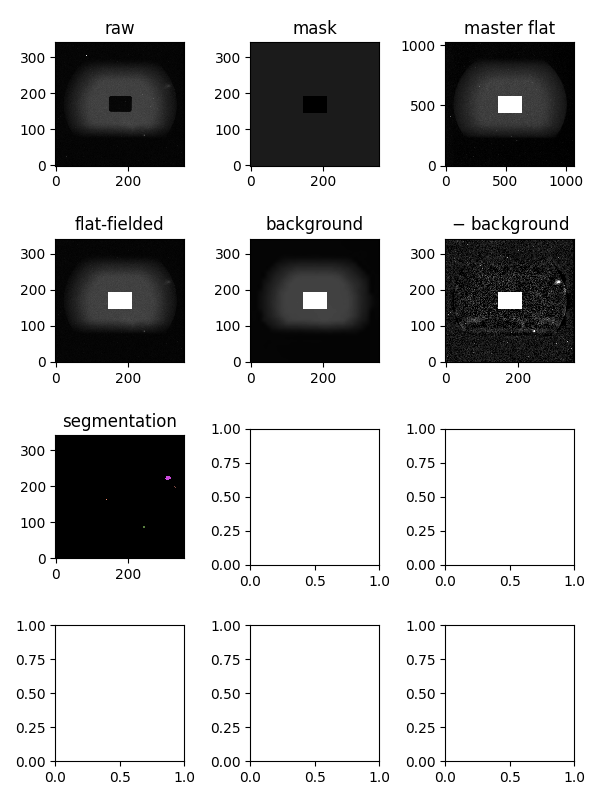

In [24]:
# OBK-549088-WiFeS-Acq--UT20231027T100925-9.fits
# OBK-544032-WiFeS-Acq--UT20231016T165032-0.fits

make_figure(15)

In [ ]:
output_dir = Path(OUTPUT_DIRS['RES']).joinpath('figures_all_2')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
for i,file in enumerate(file_list):
    try:
        make_figure(i)
    except Exception as e:
        print(f"i: {e}")
    plt.savefig(Path(output_dir).joinpath(f"{file}--{i}.png"))
    plt.gcf().clear()
    plt.close()

OBK-521792-WiFeS-Acq--UT20230919T110202-7.fits


FileNotFoundError: [Errno 2] No such file or directory: '/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_1/seeing/OBK-521792-WiFeS-Acq--UT20230919T110202-7_sources.pkl'

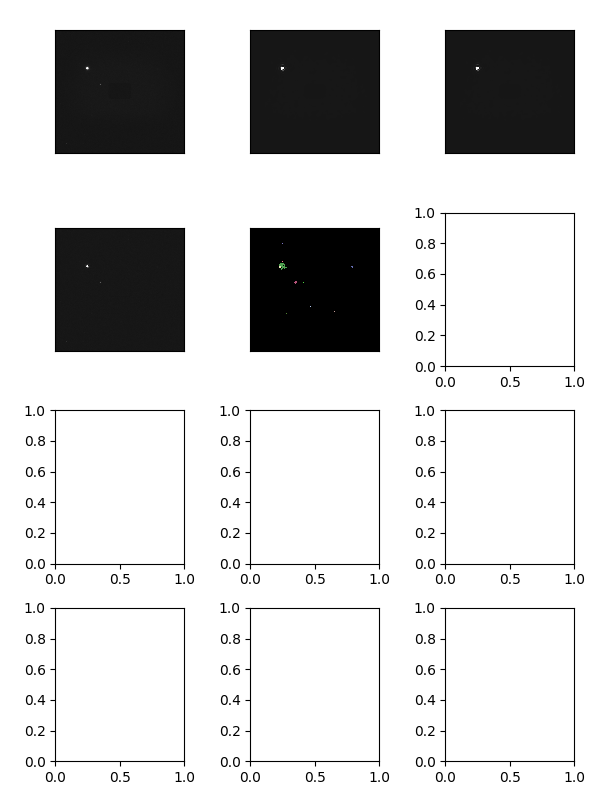

In [45]:
button_fwd = Button(description='next',distance=1)
button_bwd = Button(description='prev',distance=-1)

In [40]:
display(button_bwd.button,button_fwd.button)

Button(description='prev', style=ButtonStyle())

Button(description='next', style=ButtonStyle())

In [7]:
file_list = os.listdir(RAW_DIR)

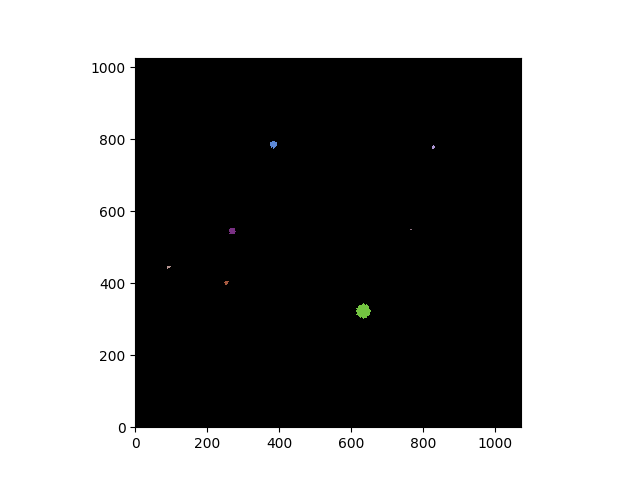

In [8]:
file = file_list[22]

segm = fits.getdata(os.path.join(OUTPUT_DIRS['DET'], file +'.segm'))
cmap = load_object(os.path.join(OUTPUT_DIRS['DET'], file +'.segm.cmap.pkl'))
plt.figure(clear=True)
plt.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
plt.show()


In [1]:
cat_table

NameError: name 'cat_table' is not defined

In [ ]:
os.path.join(OUTPUT_DIRS['DET'], file +'.segm')

'/home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.segm'

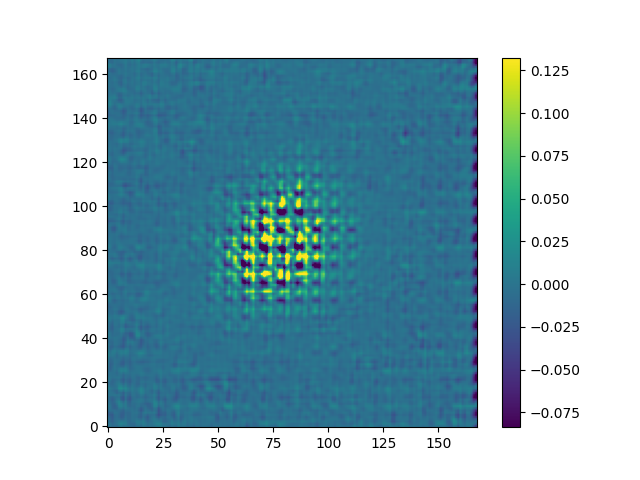

In [ ]:
psfmodel = load_object('/home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5.psfmodel.pkl')

prec = 8
size = 21*prec
x, y = np.mgrid[0:size, 0:size]/prec
center = (size//2/prec,size//2/prec)

psf_array = psfmodel.evaluate(x,y,1,*center)

norm = simple_norm(psf_array, 'power', percent=99.0)

plt.figure(clear=True)
plt.imshow(psf_array, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
plt.show()


In [ ]:
data = load_object('/home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.cutouts.fitted.pkl')
data

In [ ]:
print((cutout.shape[1]/2, cutout.shape[0]/2))
cutout.cutout_center

(13.5, 13.5)


array([11.86721878, 12.74525179])

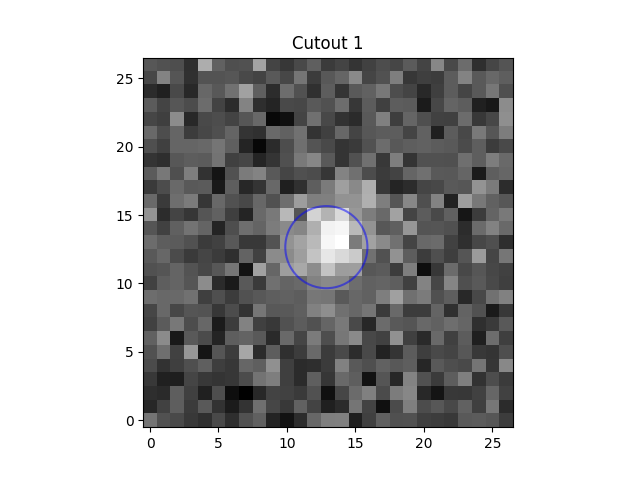

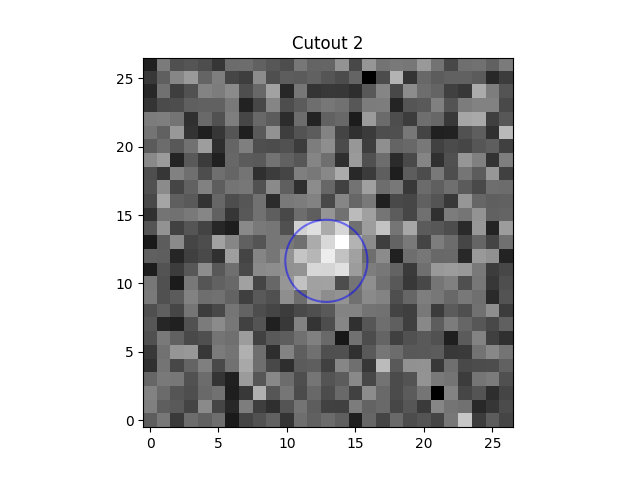

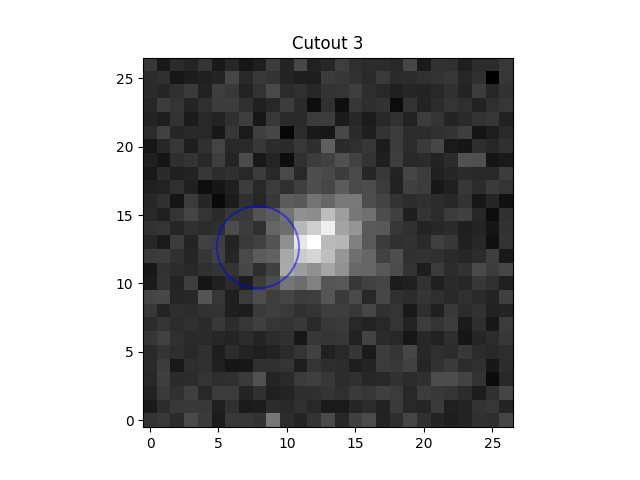

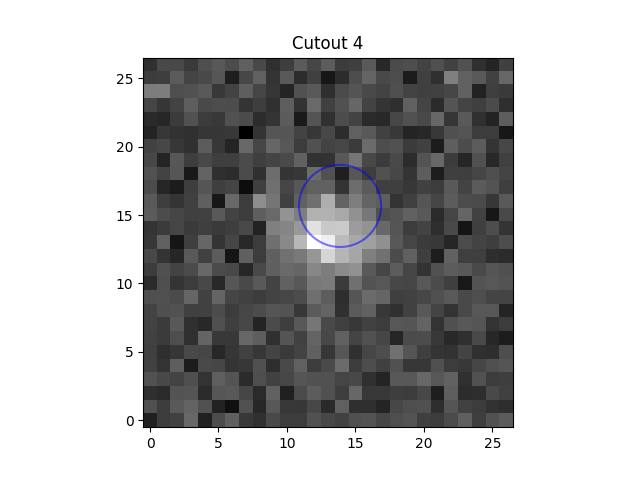

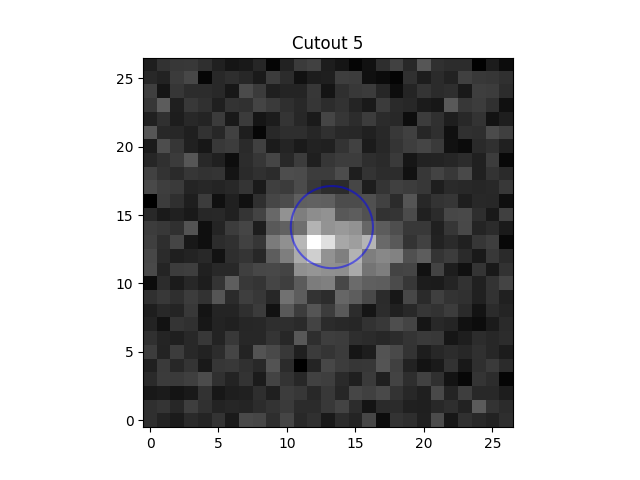

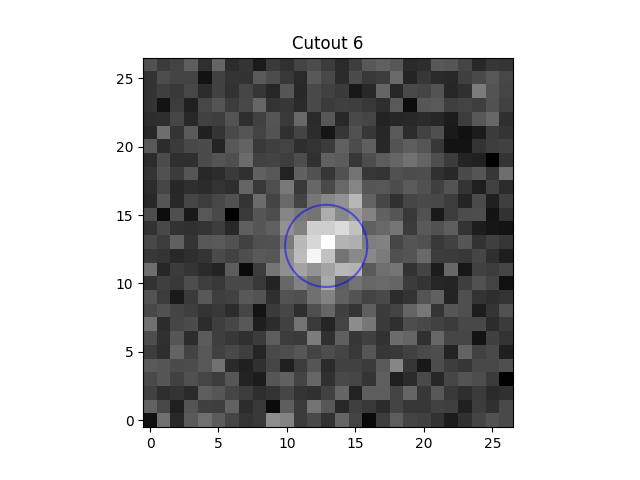

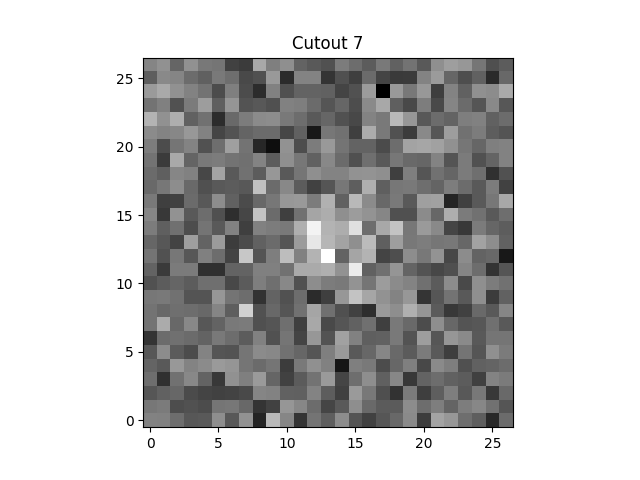

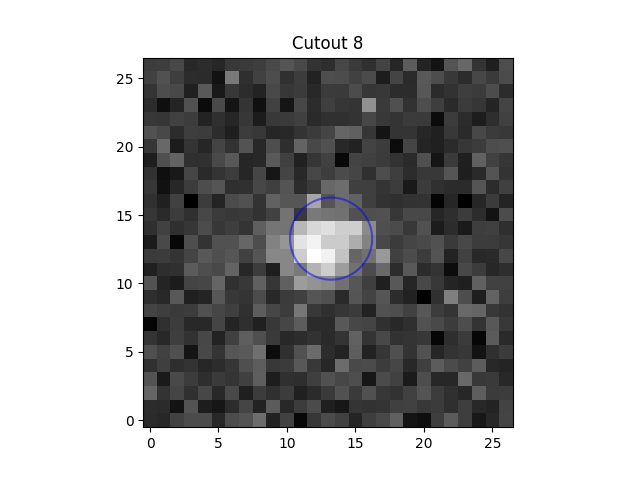

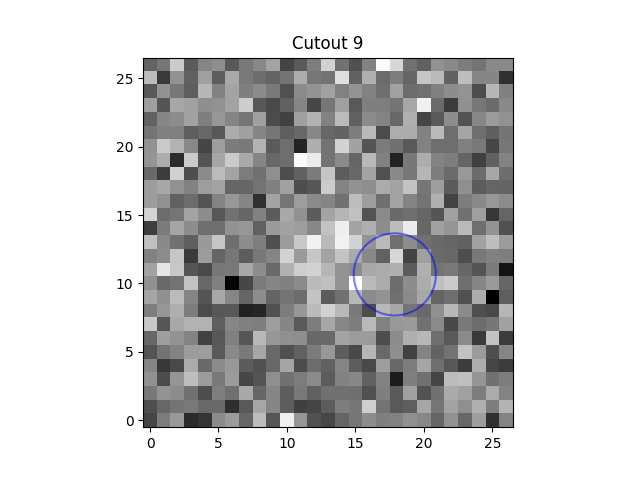

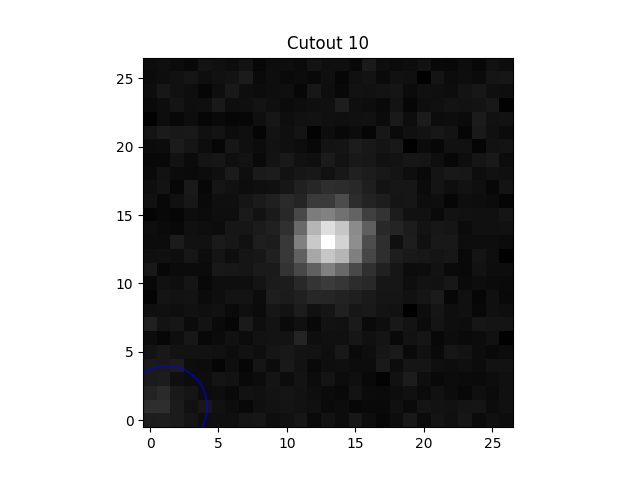

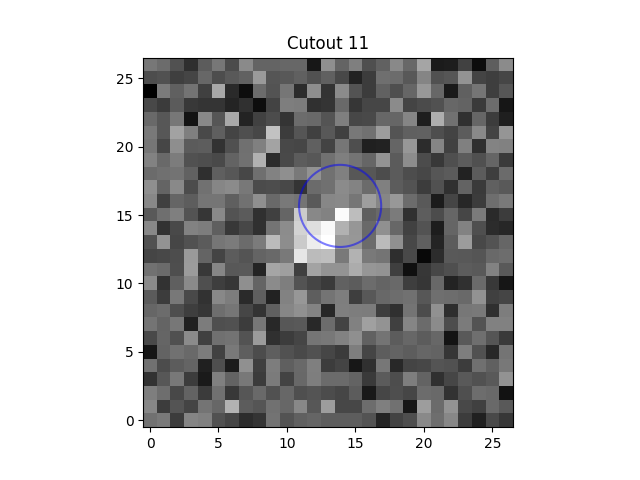

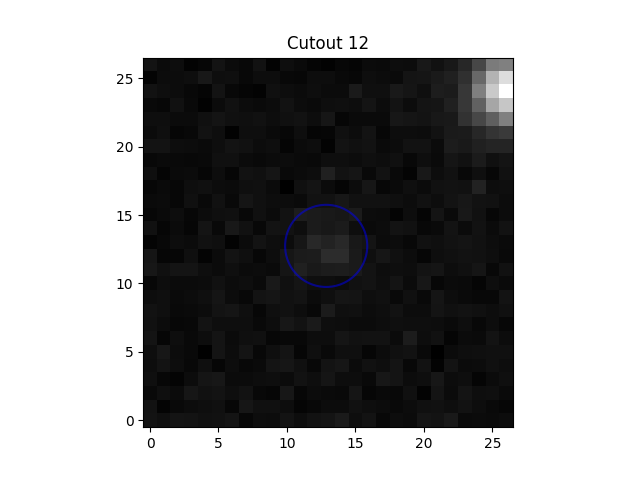

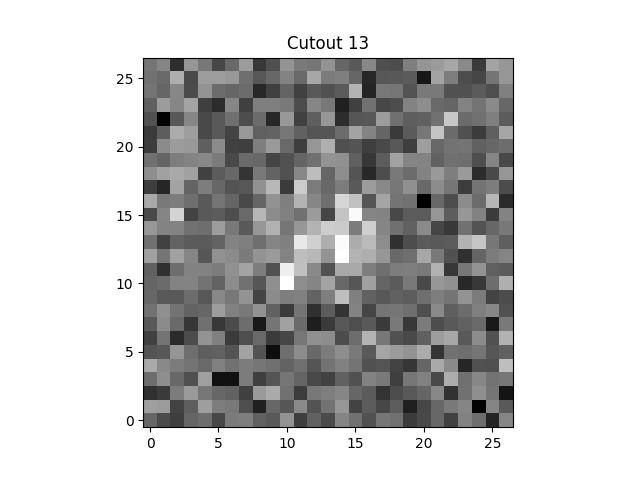

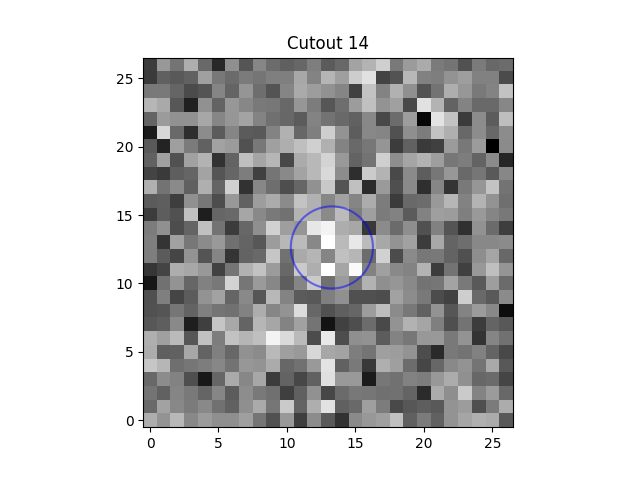

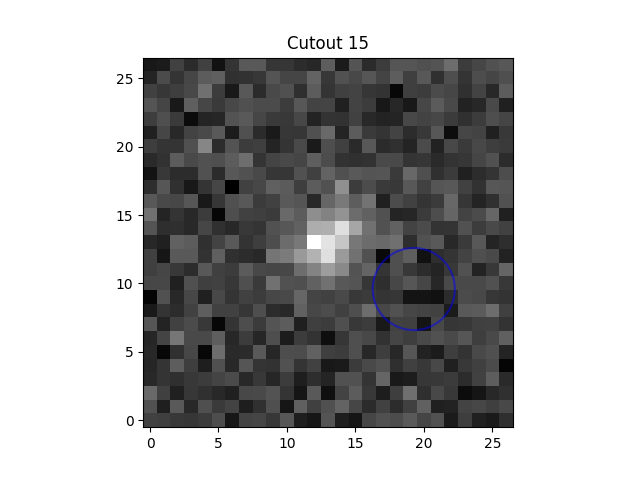

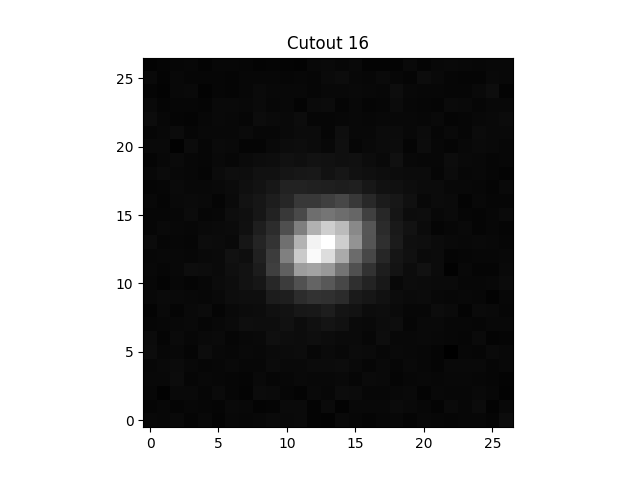

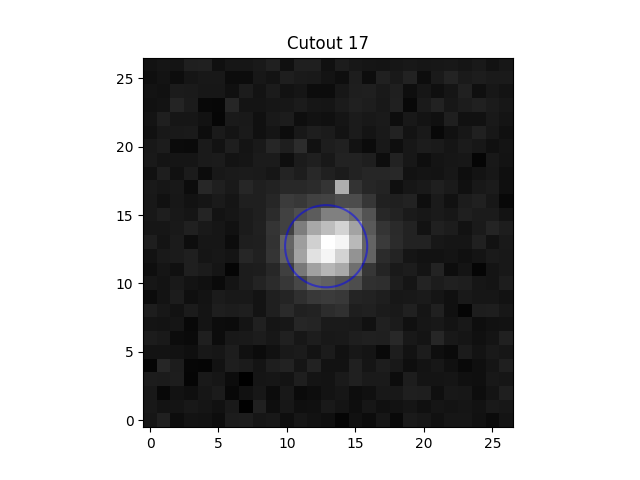

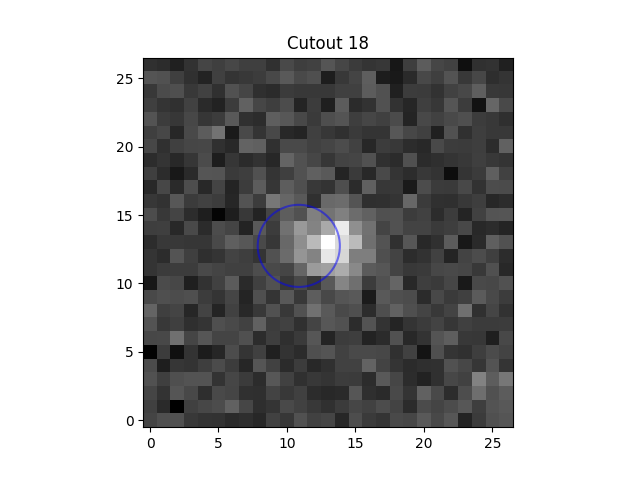

/tmp/ipykernel_781210/2112641441.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


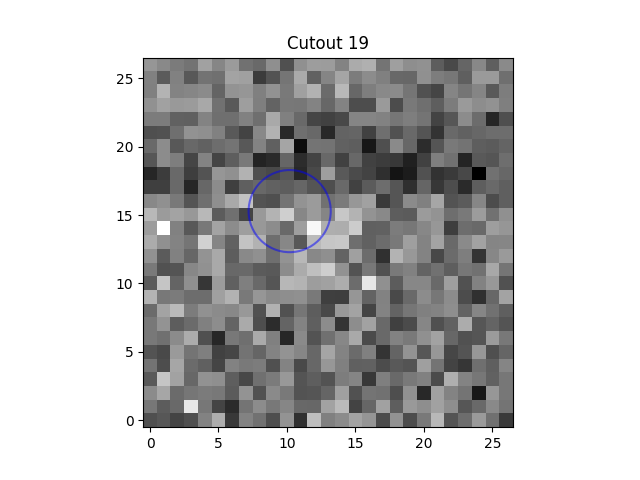

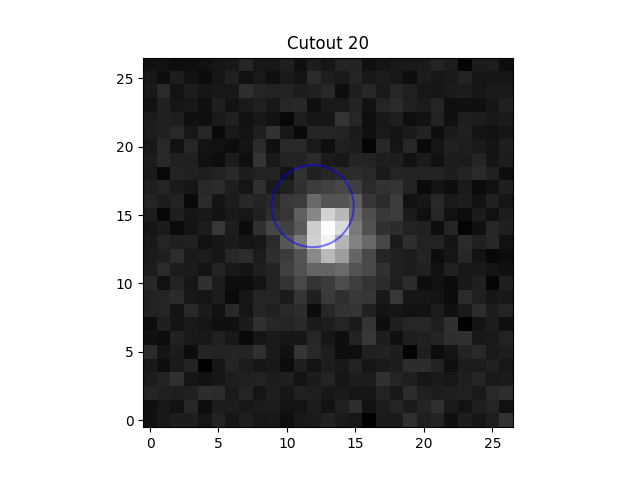

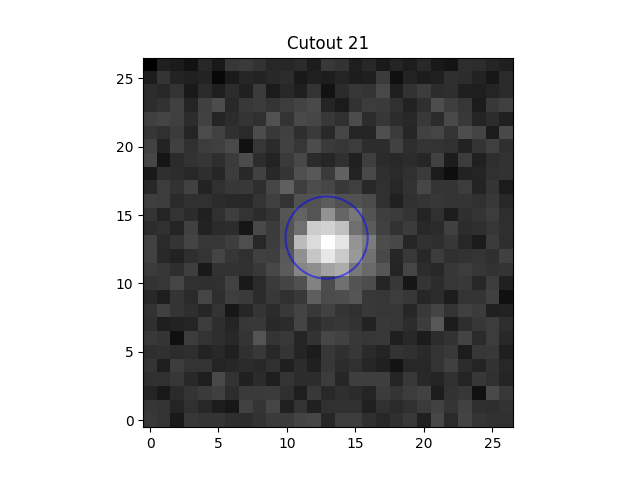

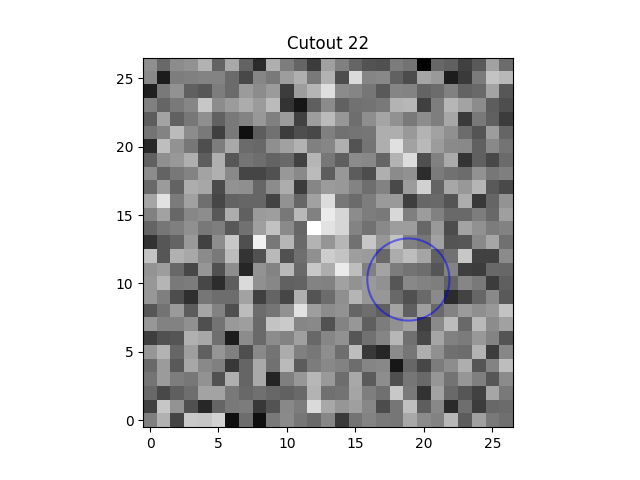

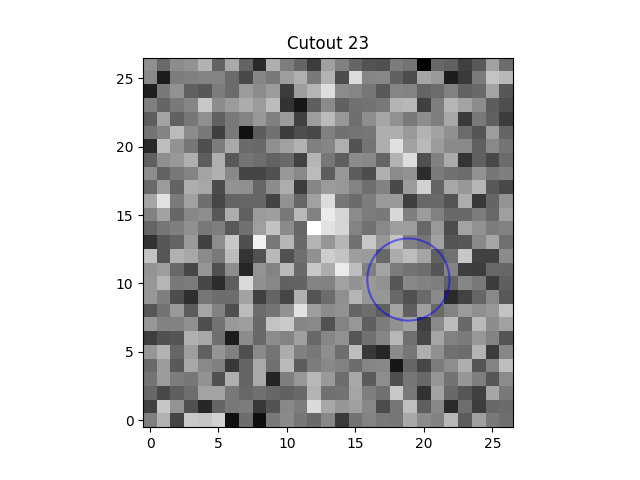

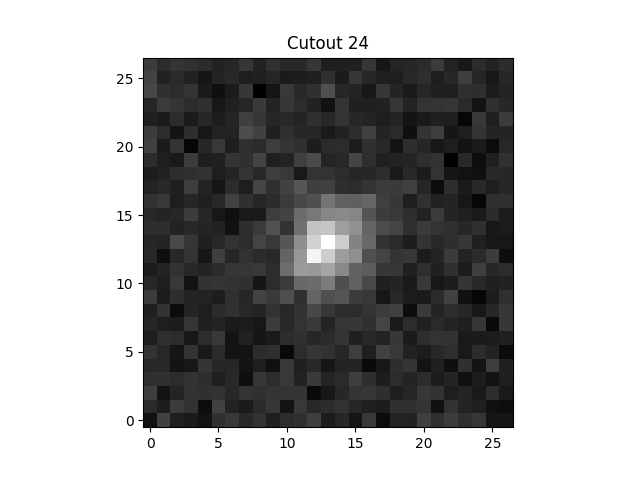

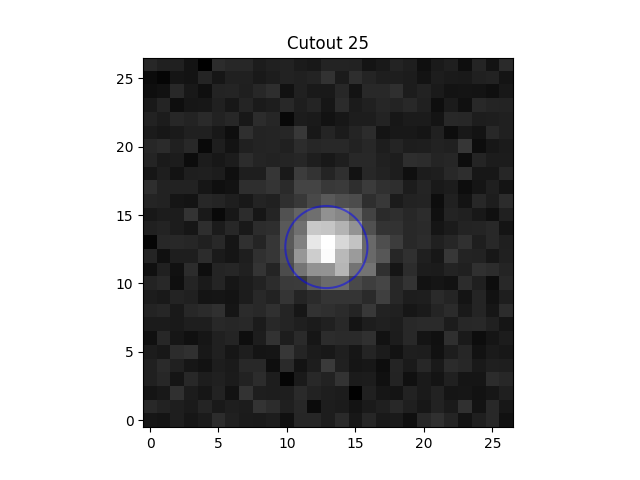

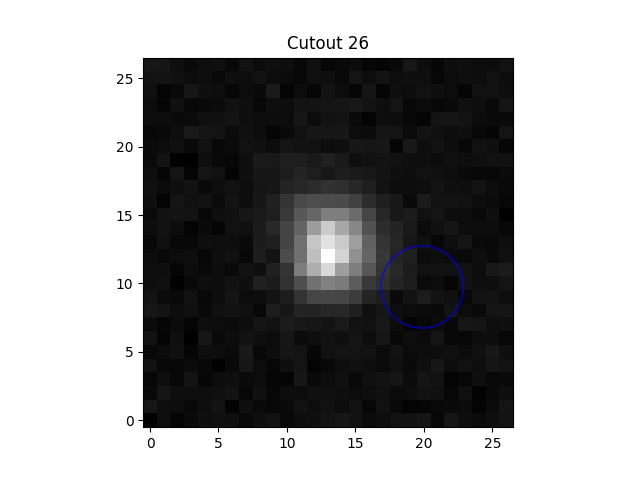

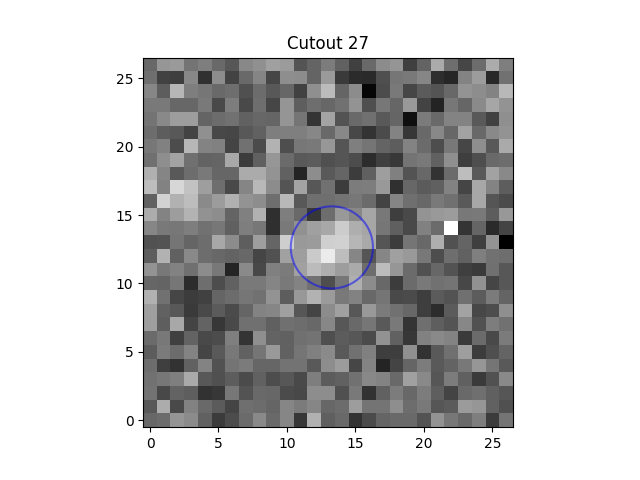

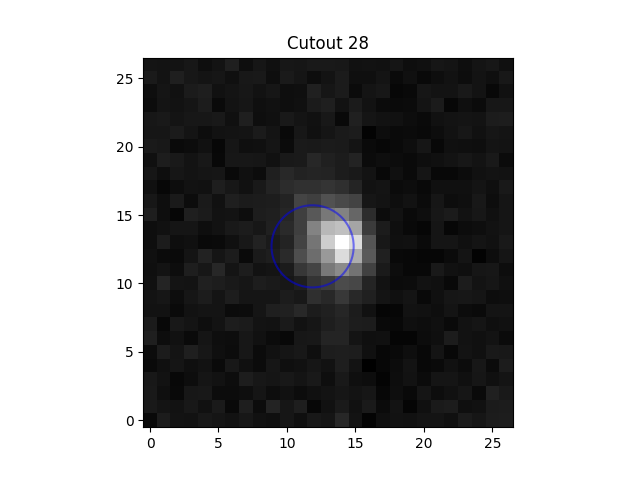

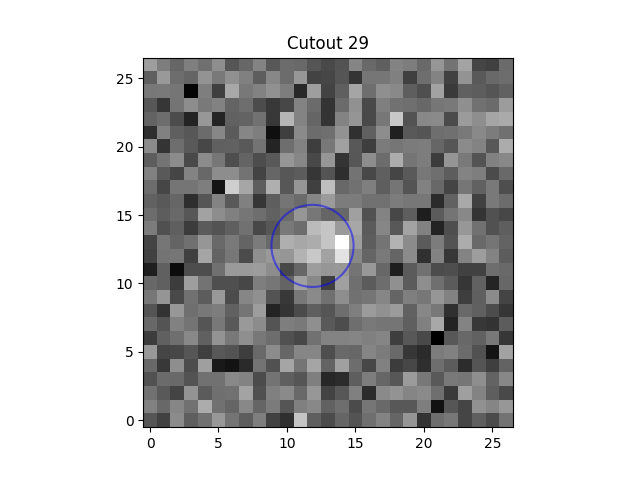

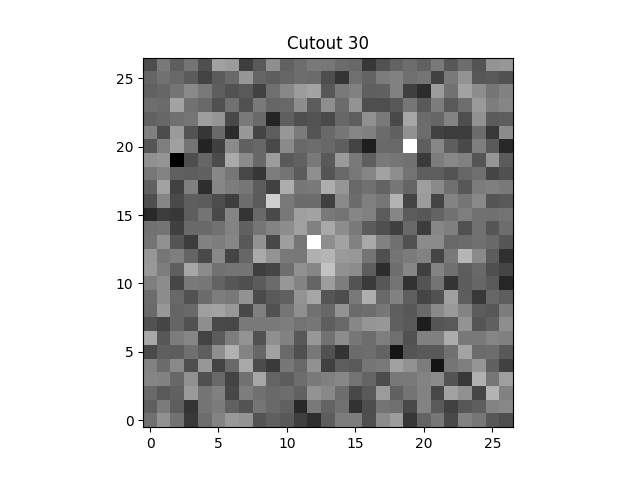

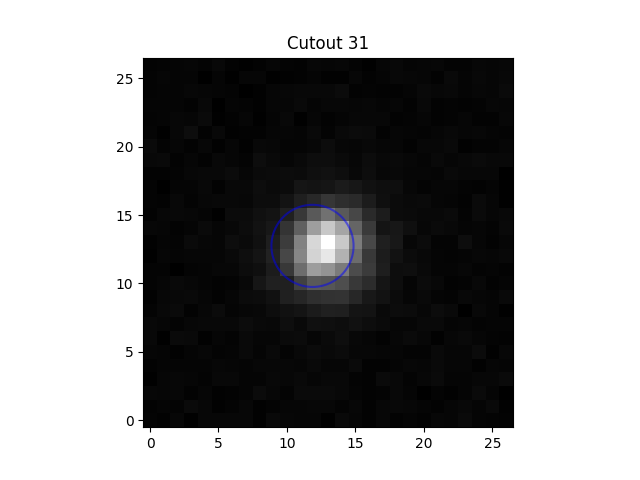

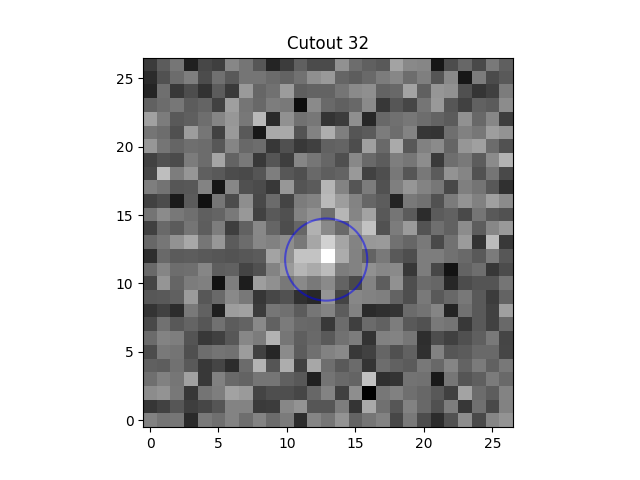

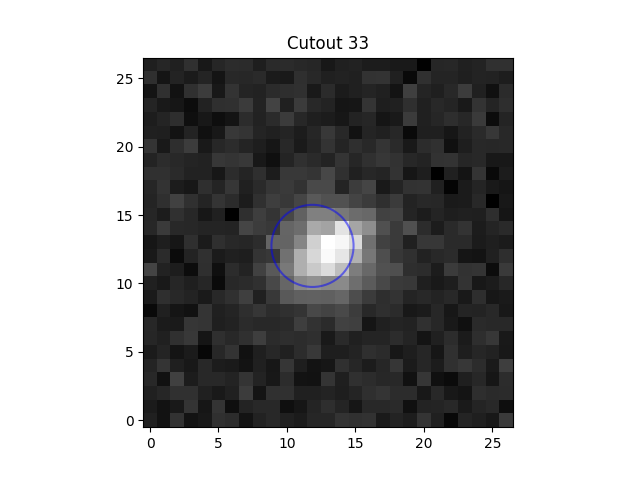

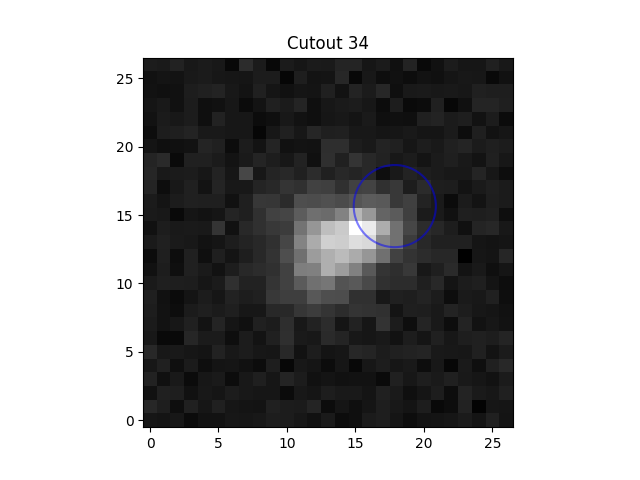

In [ ]:
cutouts = load_object('/home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.cutouts.fitted.pkl')

for i, cutout in enumerate(cutouts):
    aperture = CircularAperture(cutout.cutout_center, r=3)
    
    plt.figure()
    plt.imshow(cutout, cmap='gray', origin='lower', interpolation='nearest')
    aperture.plot(color='blue', lw=1.5, alpha=0.5)
    plt.title(f'Cutout {i+1}')
    plt.show()



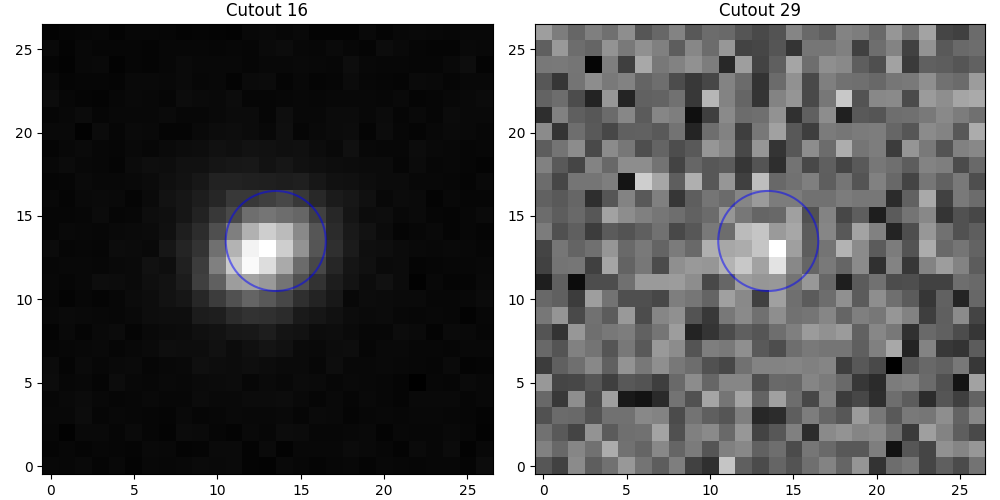

In [ ]:
cutouts = load_object('/home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.cutouts.fitted.pkl')

brightness_values = [np.sum(cutout) for cutout in cutouts]
brightest_cutout_index = np.argmax(brightness_values)
dimmest_cutout_index = np.argmin(brightness_values)

indices = [brightest_cutout_index, dimmest_cutout_index]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i, ax in zip(indices, axs):
    cutout = cutouts[i]
    aperture = CircularAperture((cutout.shape[1]/2, cutout.shape[0]/2), r=3)
    
    ax.imshow(cutout, cmap='gray', origin='lower', interpolation='nearest')
    aperture.plot(color='blue', lw=1.5, alpha=0.5, ax=ax)
    ax.set_title(f'Cutout {i+1}')

plt.tight_layout()
plt.show()


In [ ]:
data = load_object('/home/mf/Desktop/Courses/Summner-Intership-2024/OBK-510368-WiFeS-Acq--UT20230805T160231-3_sources.pkl').get_data()
data


,label,xcentroid,ycentroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr,NUMBER,fwhm,ellipticity,elong,xpos,ypos,xcentroid_win,ycentroid_win,aimage,bimage,THETA_IMAGE,ALPHAWIN_J2000,DELTAWIN_J2000,X_IMAGE,Y_IMAGE,FWHM_IMAGE,FWHM_WORLD,MAG_AUTO,FLAGS,DIFFPATH,SCIPATH,REFPATH,Gal,magnitude
0,2,938.192314,512.384681,936,941,510,515,26.0,1.735056,1.207509,47.927079,0.718092,-3.756268,61.132051,-0.161193,750.555619,NaN,1406.099983,NaN,2,3.519845,0.304052,1.436889,938.192314,512.384681,938.258978,512.623796,1.735056,1.207509,47.927079,34.561275,-31.371183,938.258978,512.623796,3.519845,0.000279,-7.870041,0,b'/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test...,NaN,NaN,0,14.053069


In [ ]:
2*np.sqrt(2*np.log(2))

2.3548200450309493

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_1/mask/OBK-548800-WiFeS-Acq--UT20231027T125316-9.mask.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      74   (357, 342)   float64   


<Axes: title={'center': 'mask/OBK-548800-WiFeS-Acq--UT20231027T125316-9.mask.fits'}, xlabel='x pixel', ylabel='y pixel'>

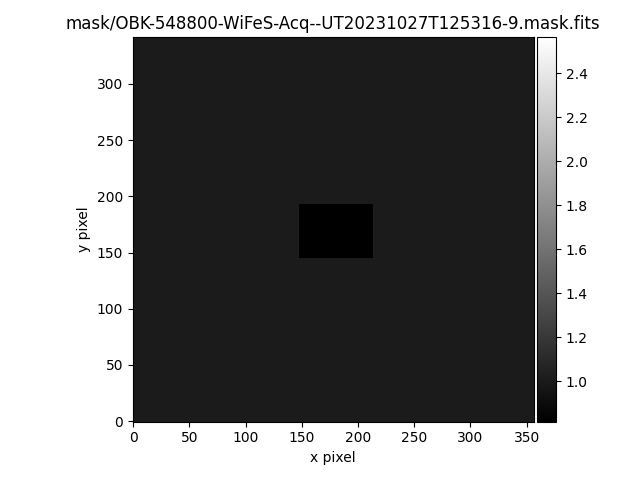

In [30]:
img = Fits('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_1/mask/OBK-548800-WiFeS-Acq--UT20231027T125316-9.mask.fits')
img.data[0] -= np.min(img.data[0])
img.image()

In [21]:
min = 

False

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_1/mask/OBK-501152-WiFeS-Acq--UT20230802T125641-2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   (536, 513)   float64   


<Axes: title={'center': 'mask/OBK-501152-WiFeS-Acq--UT20230802T125641-2.fits'}, xlabel='x pixel', ylabel='y pixel'>

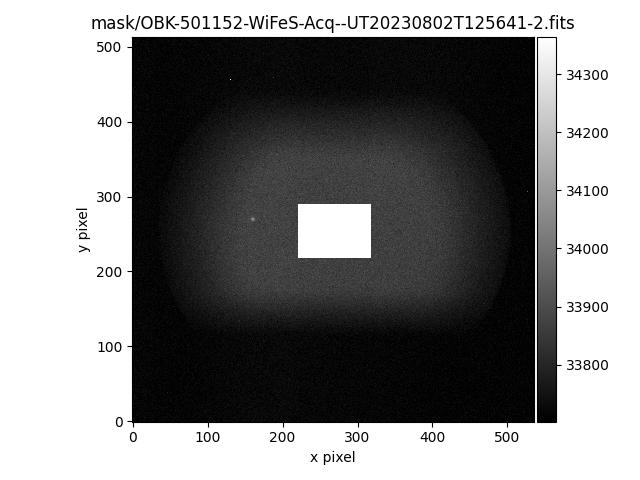

In [9]:
img = Fits('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_1/mask/OBK-501152-WiFeS-Acq--UT20230802T125641-2.fits')
img.image()

Filename: /Users/astqx/Desktop/WiFeS/WiFeS_seeing/mirar/mirar/pipelines/wirc/wirc_files/files/master_flat_H.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (2048, 2048)   float64   


<Axes: title={'center': 'files/master_flat_H.fits'}, xlabel='x pixel', ylabel='y pixel'>

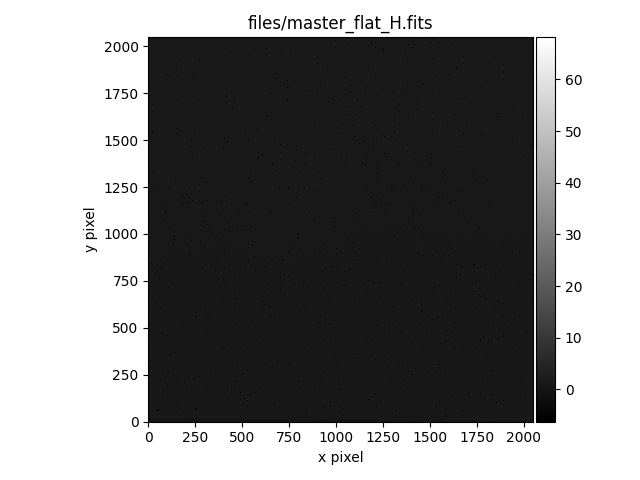

In [9]:
img = Fits('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/mirar/mirar/pipelines/wirc/wirc_files/files/master_flat_H.fits')
img.image()

In [26]:
chris_dir = Path(ROOT_DIR).joinpath('chris')
file_paths = [
    '/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_master_flat/raw/OBK-519040-WiFeS-Acq--UT20230905T100531-2.fits',
    '/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_master_flat/raw/OBK-510720-WiFeS-Acq--UT20230806T122851-3.fits',
    '/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_master_flat/raw/OBK-520384-WiFeS-Acq--UT20230916T093218-8.fits'
]
for path in file_paths:
    shutil.copy(path,chris_dir.joinpath(Path(path).name))

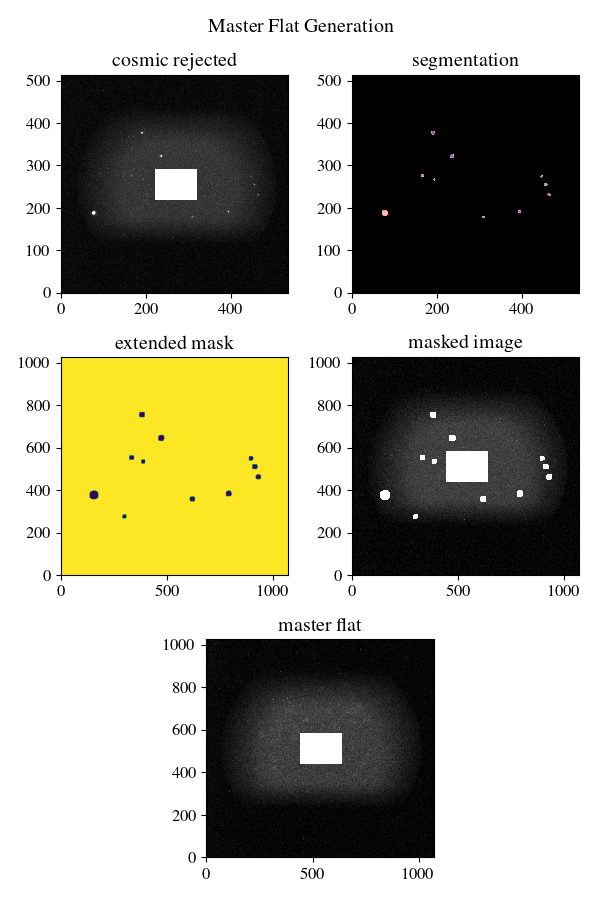

In [40]:
plt.rcParams["font.family"] = "Times"
plt.rcParams["font.size"] = 12

fig, ax = plt.subplot_mosaic('ab;cd;ee',layout='tight',figsize=(6,9))

data = fits.getdata('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_master_flat/cosmic/OBK-510720-WiFeS-Acq--UT20230806T122851-3.fits')
ax['a'].imshow(data,**make_imshow_params(data))
ax['a'].set_title('cosmic rejected')

data = fits.getdata('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_master_flat/detection/OBK-510720-WiFeS-Acq--UT20230806T122851-3.fits.segm')
cmap = load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_master_flat/detection/OBK-510720-WiFeS-Acq--UT20230806T122851-3.fits.segm.cmap.pkl')
ax['b'].imshow(data,cmap=cmap,origin='lower')
ax['b'].set_title('segmentation')

data = fits.getdata('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_master_flat/flat/OBK-510720-WiFeS-Acq--UT20230806T122851-3.mask.fits')
ax['c'].imshow(data,origin='lower')
ax['c'].set_title('extended mask')

data = fits.getdata('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_master_flat/flat/OBK-510720-WiFeS-Acq--UT20230806T122851-3.fits')
ax['d'].imshow(data,**make_imshow_params(data))
ax['d'].set_title('masked image')

data = fits.getdata('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_master_flat/calibration/flat_6dfd6f48168e753b4456a409fcc2415c721c5977.fits')
ax['e'].imshow(data,**make_imshow_params(data))
ax['e'].set_title('master flat')

fig.suptitle('Master Flat Generation')
# fig.supxlabel('x pixel')
# fig.supylabel('y pixel')
# plt.savefig()
plt.show()